# Vanilla model


In [ ]:
from plot import training_log

training_log(version=[8])

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
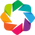

BokehModel(combine_events=True, render_bundle={'docs_json': {'22e9db90-11dd-427f-ac7d-2b0884df03bd': {'version…

In [2]:
import os

import torch
import yaml
from models.lit_model import LitModel
from numpy import random
from data.dataset import MCSims
from plot.plot import plot_field_xy_from_tensor
import holoviews as hv

hv.extension("bokeh")
device = "cpu"

version = 8
path = f"lightning_logs/version_{version}/"

with open(os.path.join(path, "hparams.yaml"), "r") as f:
    config = yaml.safe_load(f)

litmodel = LitModel(
    model_type=config["model_type"],
    config=config["config"],
    learning_rate=config["learning_rate"],
)

litmodel.model.load_state_dict(torch.load(os.path.join(path, "model.pth")))

dataset = MCSims(augment=False, preprocess=False)
n = 1071

original = dataset[n].float()  # Convert to float
model = litmodel.model
model.eval()
reconstruct = model(original.unsqueeze(0).to(device))[0].squeeze(0).detach().cpu()

plot_field_xy_from_tensor(original) + plot_field_xy_from_tensor(reconstruct)


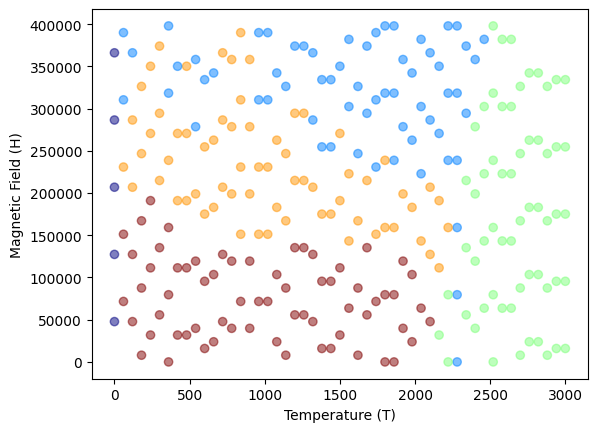

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# load the df from the csv file
hf = pd.read_csv("data/dataset.csv")

# Plot H vs T with labels scatter
plt.scatter(hf["T"], hf["H"], c=hf["label"], cmap="jet", alpha=0.5)
plt.xlabel("Temperature (T)")
plt.ylabel("Magnetic Field (H)")
plt.show()

In [3]:

import torch
import hdbscan
#from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from plot.plot import plot_H_vs_T_with_hover

# Encode the dataset
encoded_data = torch.load("lightning_logs/version_8/encoded_data.pth").cpu().numpy()

# labels = hdbscan.HDBSCAN(min_cluster_size=15, cluster_selection_epsilon=0.06).fit_predict(encoded_data)
labels = GaussianMixture(n_components=6, covariance_type='diag').fit_predict(encoded_data)
# labels = BayesianGaussianMixture(n_components=6, covariance_type='spherical').fit_predict(encoded_data)
plot_H_vs_T_with_hover(labels=labels)

FigureWidget({
    'data': [{'customdata': {'bdata': ('AAABAAIAAwAEAAUABgBmAGcAaABpAG' ... 'nICckJygnLCcwJzQnOCc8J0AnRCQ=='),
                             'dtype': 'i2'},
              'hovertemplate': 'T: %{x}<br>H: %{y}<extra></extra>',
              'marker': {'color': '#2E91E5', 'size': 10},
              'mode': 'markers',
              'name': 'Cluster 2',
              'type': 'scatter',
              'uid': '58f47650-431a-4349-83cd-df73835605a4',
              'x': {'bdata': ('AAAAAADQoUAAAAAAANChQAAAAAAA0K' ... 'AAGKVAAAAAAAAYpUAAAAAAABilQA=='),
                    'dtype': 'f8'},
              'y': {'bdata': ('AAAAAAAAAADEVz1FvxW/QMZXPUW/Fc' ... 'NPUPdATtdBaKtB+UDNrJVcBzP7QA=='),
                    'dtype': 'f8'}},
             {'customdata': {'bdata': ('BwAIAAkACgALAAwADQAOAA8AEAARAB' ... 'nsCe0J7gnvCfAJ8QnyCfMJ9An1CQ=='),
                             'dtype': 'i2'},
              'hovertemplate': 'T: %{x}<br>H: %{y}<extra></extra>',
              'marker': {'color': '#E15F

In [4]:
import pandas as pd
import torch
from sklearn.mixture import GaussianMixture

# measure the Adjusted Rand Index for a subset of the data
from sklearn.metrics import adjusted_rand_score
import numpy as np
from sklearn.metrics.cluster import contingency_matrix

true_df = pd.read_csv("data/dataset.csv")

true_labels = true_df["label"].values

# make a list of predicted labels which are oniy the labels in of index id from true_labels

predicted_labels = [labels[10 * i] for i in range(261)]


# calculate the Adjusted Rand Index
ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index: {ari:.4f}")

def purity_score(y_true, y_pred):
    matrix = contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(matrix, axis=0)) / np.sum(matrix)
purity = purity_score(true_labels, predicted_labels)
print(f"Purity Score: {purity:.4f}")


Adjusted Rand Index: 0.6142
Purity Score: 0.8774


In [4]:
from data.dataset import MCSims

# Load dataset
dataset = MCSims()
df = dataset.data_frame.copy()

import torch
import hdbscan
#from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from plot.plot import plot_H_vs_T_with_hover

# Encode the dataset
encoded_data = torch.load("lightning_logs/version_8/encoded_data.pth").cpu().numpy()

# labels = hdbscan.HDBSCAN(min_cluster_size=15, cluster_selection_epsilon=0.06).fit_predict(encoded_data)
labels = GaussianMixture(n_components=6, covariance_type='diag').fit_predict(encoded_data)

df["cluster"] = labels

df.to_csv("dask_app_viz/dataset.csv", index=False)  # Save the updated DataFrame to a new CSV file